In [586]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics, preprocessing

# import xgboost as xgb
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.model_selection import (
    GridSearchCV,
    TimeSeriesSplit,
    cross_val_predict,
    cross_val_score,
)

In [587]:
df = pd.read_csv(
    "ВС_DS_Сбер.csv",
    delimiter=";",
    parse_dates={"date": ["REPORTDATE"]},
    infer_datetime_format=True,
)
df = df.rename(columns={"VALUE": "value"})
df["time"] = np.arange(len(df.index))

df.describe()

,value,time
count,2.111000e+03,2111.00000
mean,3.389668e+10,1055.00000
std,1.875474e+10,609.53753
min,3.282810e+09,0.00000
25%,1.824160e+10,527.50000
50%,3.021352e+10,1055.00000
75%,4.758339e+10,1582.50000
max,7.822860e+10,2110.00000


In [588]:
month_period = 1
hor = month_period * 30

df["std"] = df.value.rolling(hor).std()
df["sma"] = df.value.rolling(hor).mean()
df["lbb"] = df.sma - df["std"] * 1.2
df["lag1"] = df.value.shift(1)
df["lag_days"] = ((df.date - pd.DateOffset(months=month_period)) - df.date).dt.days
df["forward_days"] = ((df.date + pd.DateOffset(months=month_period)) - df.date).dt.days

lagg = df.time + df.lag_days
forw = df.time + df.forward_days
forw_diff = forw[len(df.index) - 1] - len(df.index) + 1
forw[-forw_diff:] = 0

df["lag"] = np.where(lagg >= 0, df.value.values[lagg], np.nan)
df["target"] = np.where(
    forw.index < len(df.index) - forw_diff, df.value.values[forw], np.nan
)

df = df.dropna()

df["change"] = 100 * (df["value"] - df["lag"]) / df["lag"]
df["target_change"] = 100 * (df["target"] - df["value"]) / df["value"]

In [589]:
X = pd.DataFrame(
    {
        "time": df["time"],
        "value": df["value"],
        # "lag": df["lag"],
        "change": df["change"],
        # "lbb": df["lbb"],
        # "sma": df["sma"],
    }
)

# y = df.target
y = df.target_change

test_size = 400
X_train, X_test, y_train, y_test = (
    X[:-test_size],
    X[-test_size:],
    y[:-test_size],
    y[-test_size:],
)

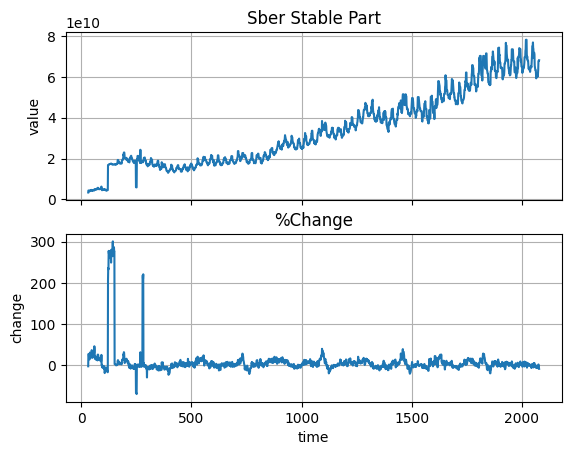

In [590]:
sta = 0
sto = 5000

fig, ax = plt.subplots(2, 1, sharex=True)
# ax.plot("time", "change", data=X[sta:sto], color="0.35")
sns.lineplot(x="time", y="change", data=X[sta:sto], ax=ax[1])
sns.lineplot(x="time", y="value", data=X[sta:sto], ax=ax[0])
# ax = sns.lineplot(x='time', y='sma', data=X[sta:sto])
# ax = sns.lineplot(x="time", y="lbb", data=X[sta:sto])
ax[0].set_title("Sber Stable Part")
ax[1].set_title("%Change")
ax[0].grid()
ax[1].grid()

In [591]:
model = GradientBoostingRegressor()
# model = AdaBoostRegressor()
param_search = {
    "loss": ["absolute_error"],
    "max_depth": [1, 2, 3],
    "n_estimators": range(50, 200, 10),
    "learning_rate": [0.1, 0.5, 1, 1.5],
}

tscv = TimeSeriesSplit(n_splits=2, test_size=test_size)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, n_jobs=12)
gsearch.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=400),
             estimator=GradientBoostingRegressor(), n_jobs=12,
             param_grid={'learning_rate': [0.1, 0.5, 1, 1.5],
                         'loss': ['absolute_error'], 'max_depth': [1, 2, 3],
                         'n_estimators': range(50, 200, 10)})

In [592]:
best = gsearch.best_estimator_
best.fit(X_train, y_train)

scores = best.score(X_test, y_test), best.score(X_train, y_train)

print(best.get_params)
print(scores)

<bound method BaseEstimator.get_params of GradientBoostingRegressor(learning_rate=1, loss='absolute_error',
                          n_estimators=160)>
(-1.9887035490122615, 0.9601636086490644)


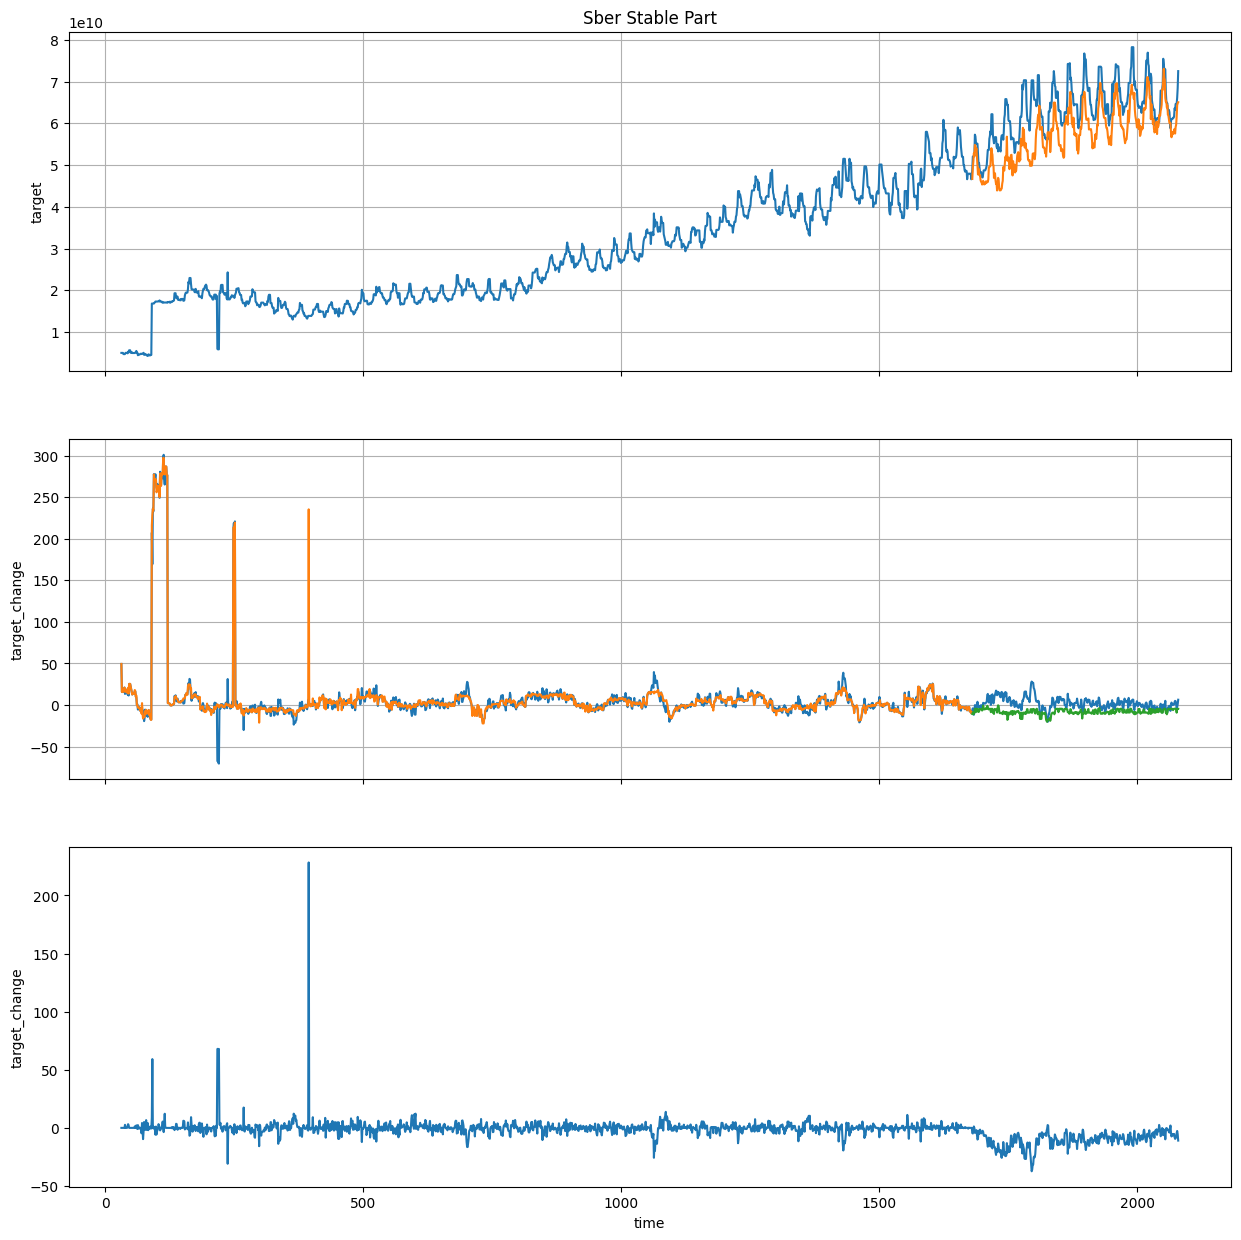

In [593]:
y_pred = best.predict(X_train)
y_pred_t = best.predict(X_test)
sta = 0

abs_err = pd.concat([y_pred - y_train, y_pred_t - y_test])
target_pred = X_test.value + y_pred_t*X_test.value/100

fig, ax = plt.subplots(3, 1, sharex=True, figsize=(15, 15))

sns.lineplot(x="time", y="target", data=df[sta:sto], ax=ax[0])
sns.lineplot(x=X_test.time, y=target_pred, ax=ax[0])

sns.lineplot(x=X.time[sta:], y=y[sta:], ax=ax[1])
sns.lineplot(x=X_train.time[sta:], y=y_pred[sta:], ax=ax[1])
sns.lineplot(x=X_test.time, y=y_pred_t, ax=ax[1])
sns.lineplot(x=X.time[sta:], y=abs_err, ax=ax[2])

ax[0].set_title("Sber Stable Part")
ax[0].grid()
ax[1].grid()